In [8]:
import sys
import logging
import importlib
from itertools import product
from pathlib import Path

import numpy as np  # type: ignore
import matplotlib  # type: ignore
from matplotlib import pyplot as plt  # type: ignore

sys.path.append('../../src/')
import utils.figures  # type: ignore # noqa: E402

In [9]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "font.family": "serif",
    "font.size": 11,
    "pgf.rcfonts": False,
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
})
plt.close('all')

In [2]:
data_dir = Path('../../data/')

In [3]:
importlib.reload(utils.figures)
from utils.figures import load_all_eliminateds_dict  # noqa: E402
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, force=True)
eliminateds = load_all_eliminateds_dict(data_dir)
logging.basicConfig(level=logging.WARNING, stream=sys.stderr, force=True)

DEBUG:root:Loading positive-mask from ../../data/benchmark_results/all-full-flat-spencer-none.jsonl
DEBUG:root:Loading negative-mask from ../../data/benchmark_results/all-full-flat-spencer-none.jsonl
DEBUG:root:Loading positive-mask from ../../data/benchmark_results/all-full-flat-spencer-cn.jsonl
DEBUG:root:Loading negative-mask from ../../data/benchmark_results/all-full-flat-spencer-cn.jsonl
DEBUG:root:Loading positive-mask from ../../data/benchmark_results/all-full-flat-spencer-in.jsonl
DEBUG:root:Loading negative-mask from ../../data/benchmark_results/all-full-flat-spencer-in.jsonl


In [4]:
importlib.reload(utils.figures)
from utils.figures import load_states_dict  # noqa: E402
logging.basicConfig(level=logging.DEBUG, stream=sys.stdout, force=True)
states = load_states_dict(data_dir)
logging.basicConfig(level=logging.WARNING, stream=sys.stderr, force=True)

DEBUG:root:Loading positive-state from ../../data/benchmark_results/all-full-thompson-spencer-none.jsonl
DEBUG:root:Loading negative-state from ../../data/benchmark_results/all-full-thompson-spencer-none.jsonl
DEBUG:root:Loading positive-state from ../../data/benchmark_results/all-full-thompson-spencer-cn.jsonl
DEBUG:root:Loading negative-state from ../../data/benchmark_results/all-full-thompson-spencer-cn.jsonl
DEBUG:root:Loading positive-state from ../../data/benchmark_results/all-full-thompson-spencer-in.jsonl
DEBUG:root:Loading negative-state from ../../data/benchmark_results/all-full-thompson-spencer-in.jsonl
DEBUG:root:Loading positive-state from ../../data/benchmark_results/all-full-thompson-lockstep-none.jsonl
DEBUG:root:Loading negative-state from ../../data/benchmark_results/all-full-thompson-lockstep-none.jsonl
DEBUG:root:Loading positive-state from ../../data/benchmark_results/all-full-flat-spencer-none.jsonl
DEBUG:root:Loading negative-state from ../../data/benchmark_resul

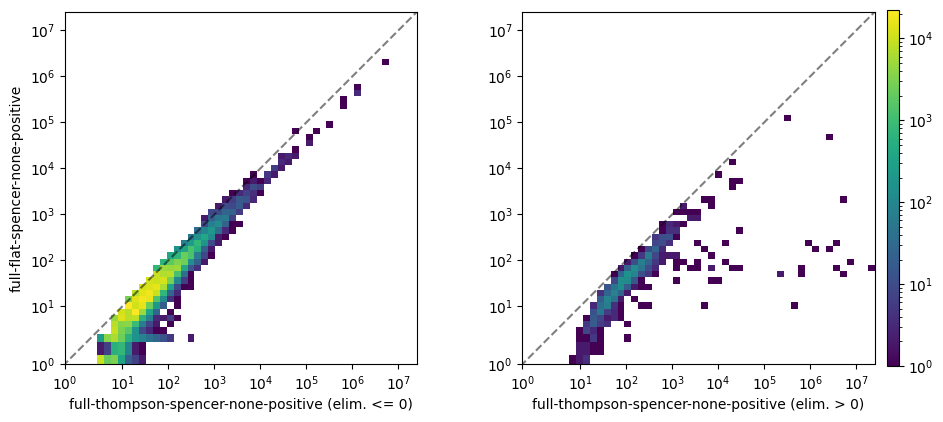

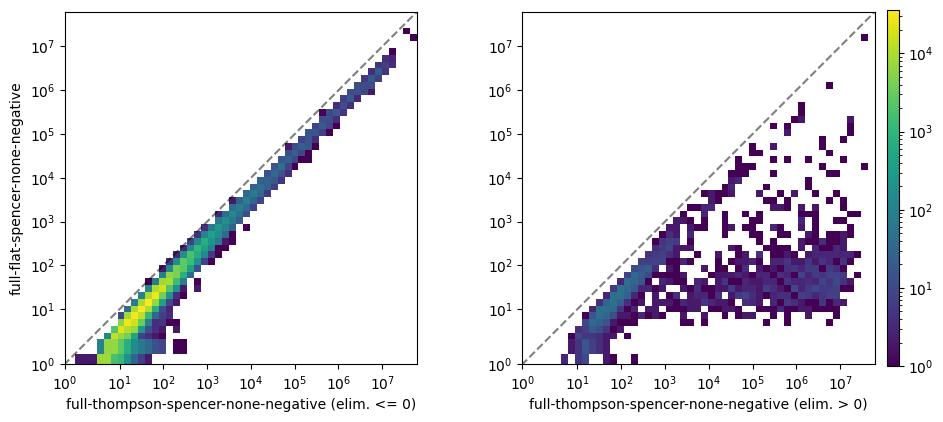

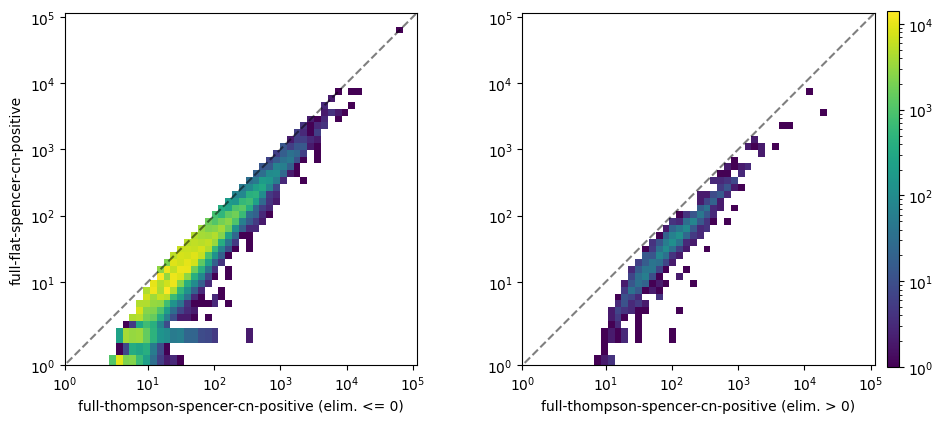

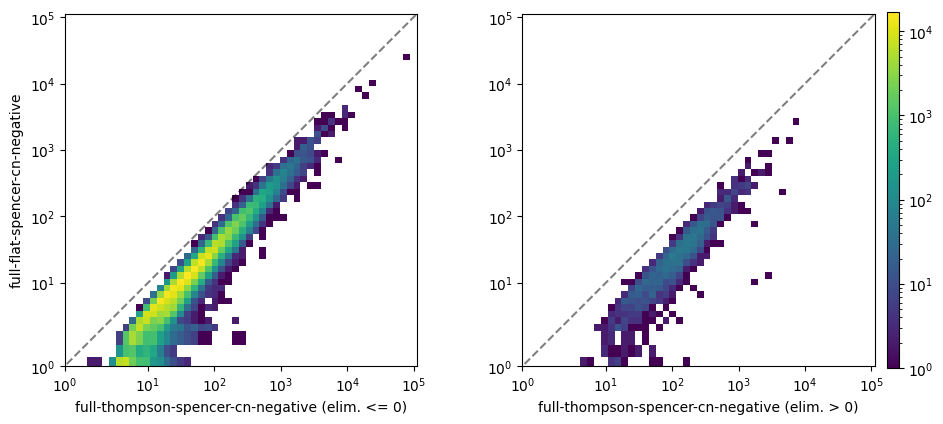

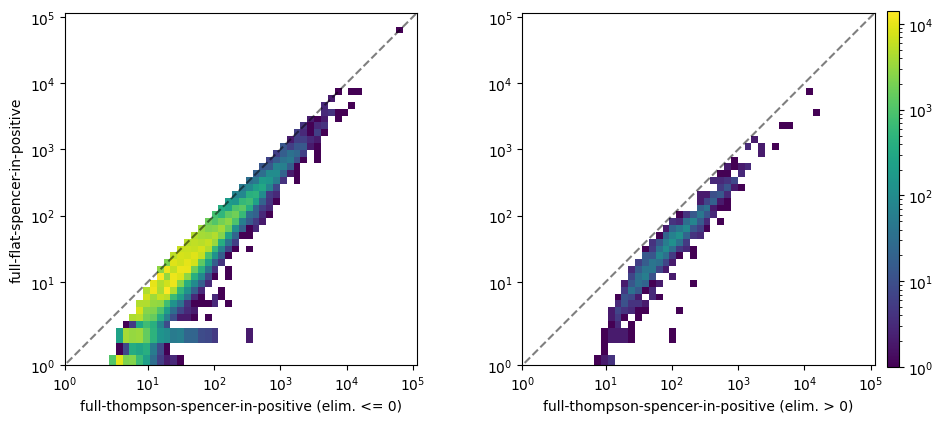

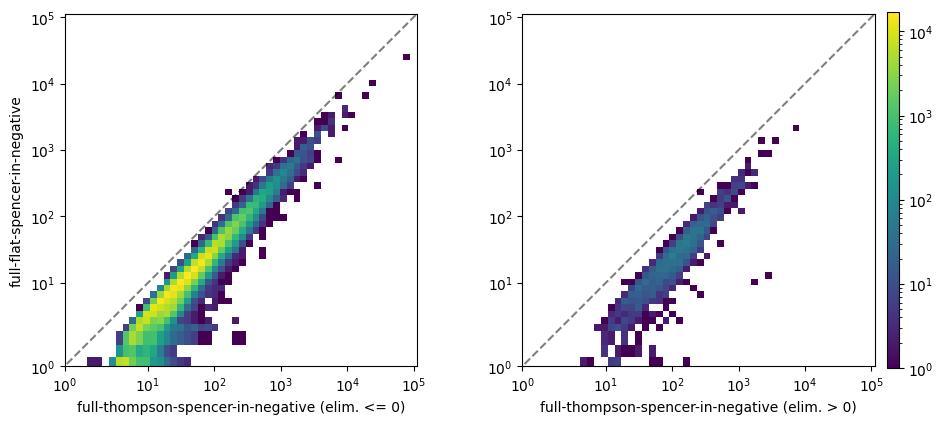

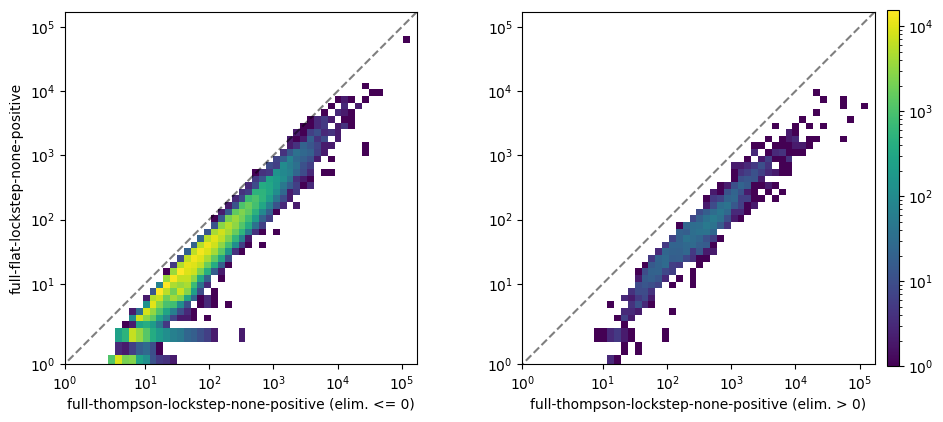

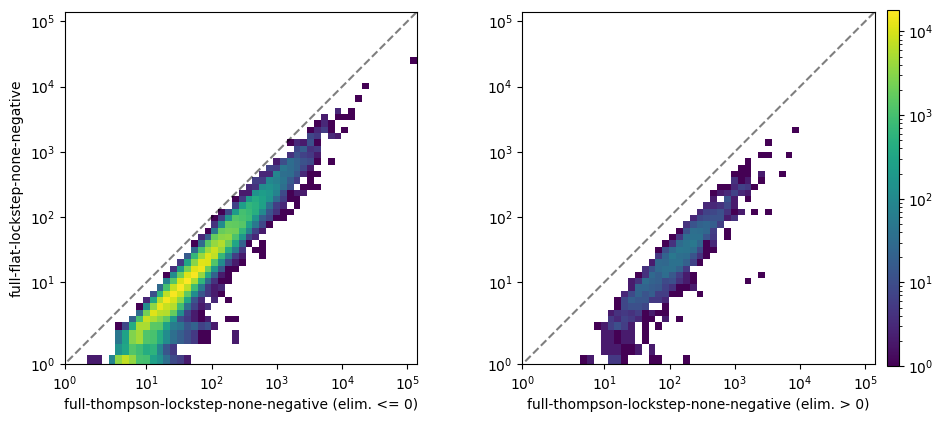

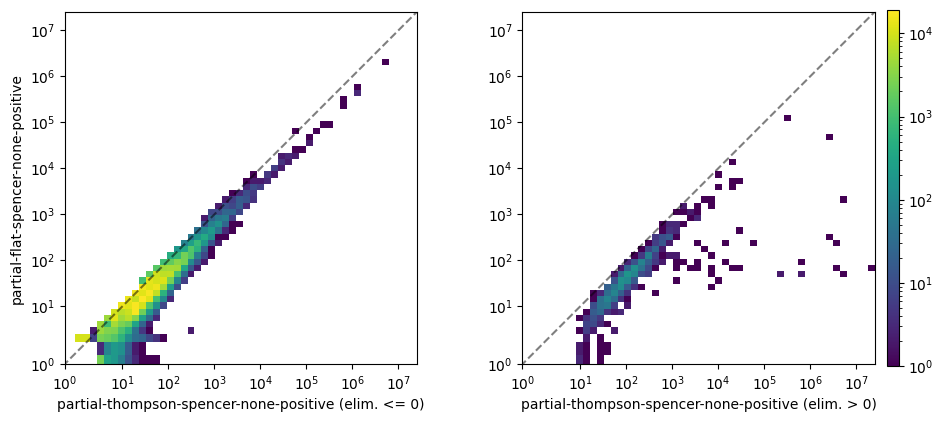

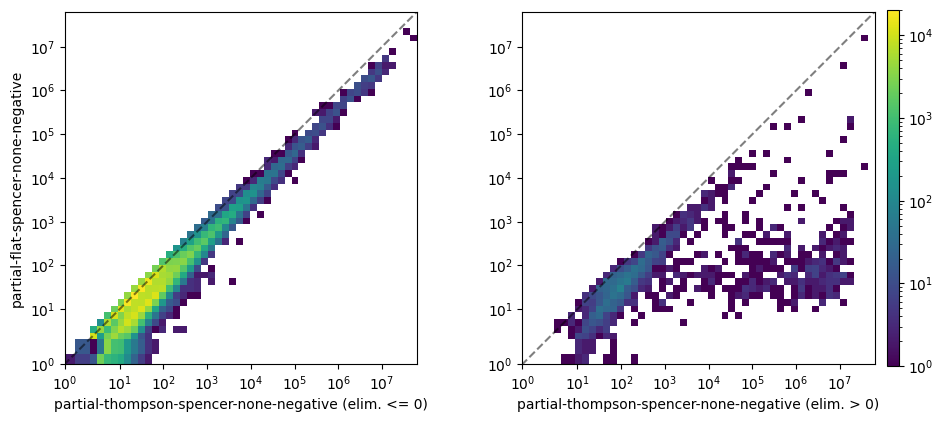

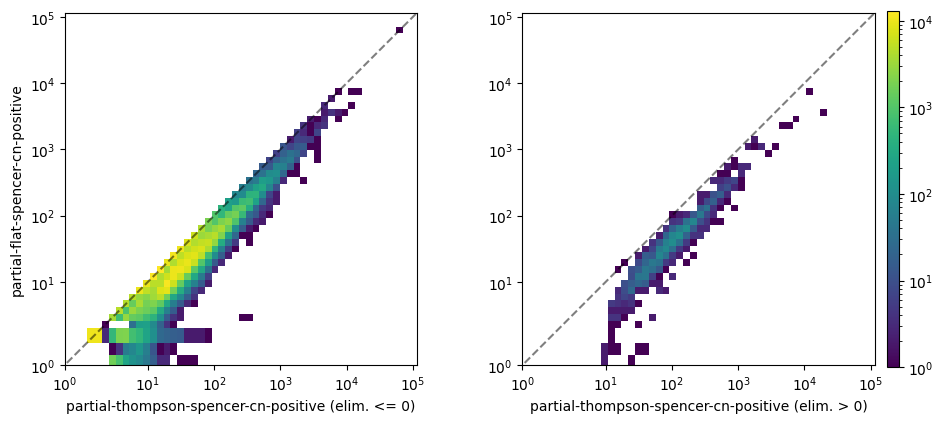

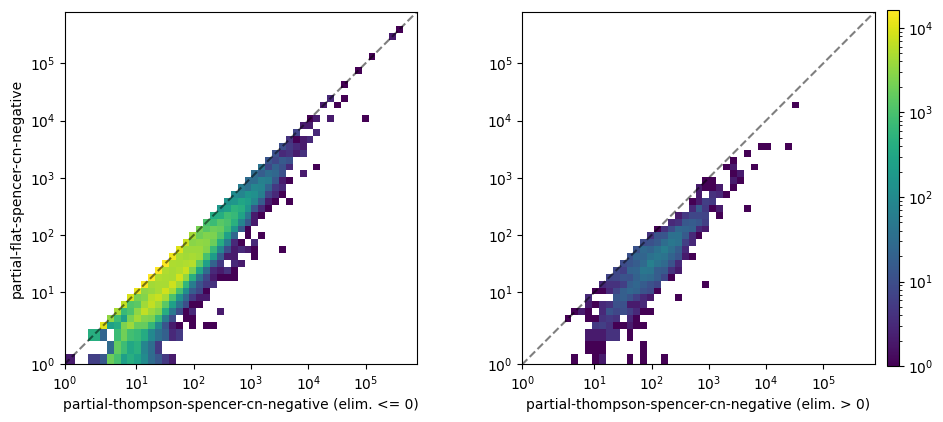

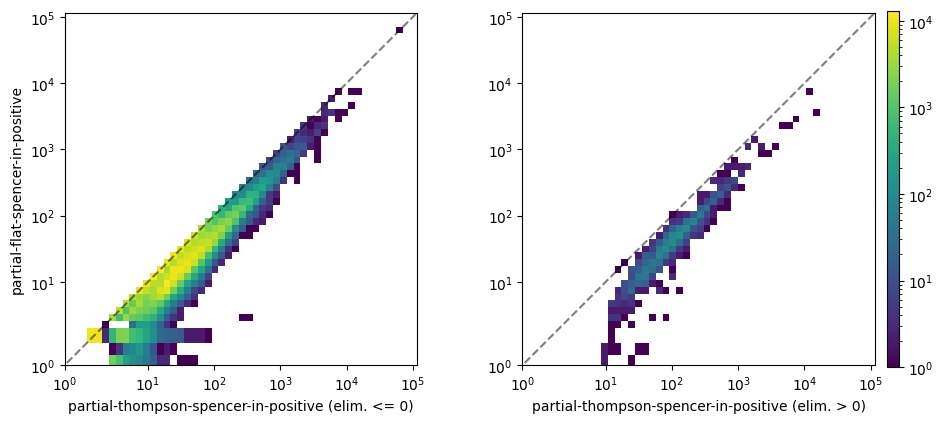

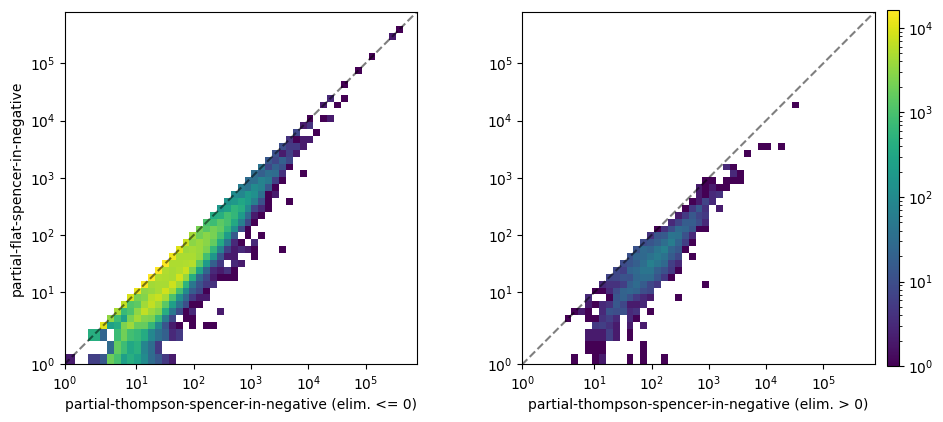

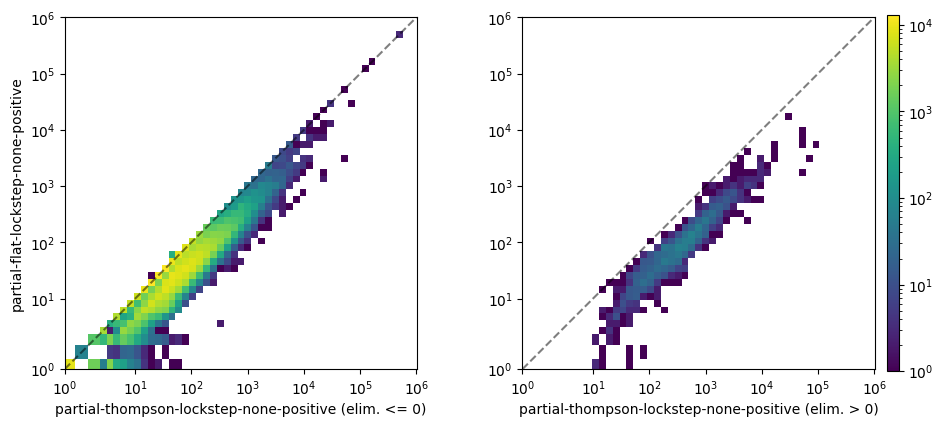

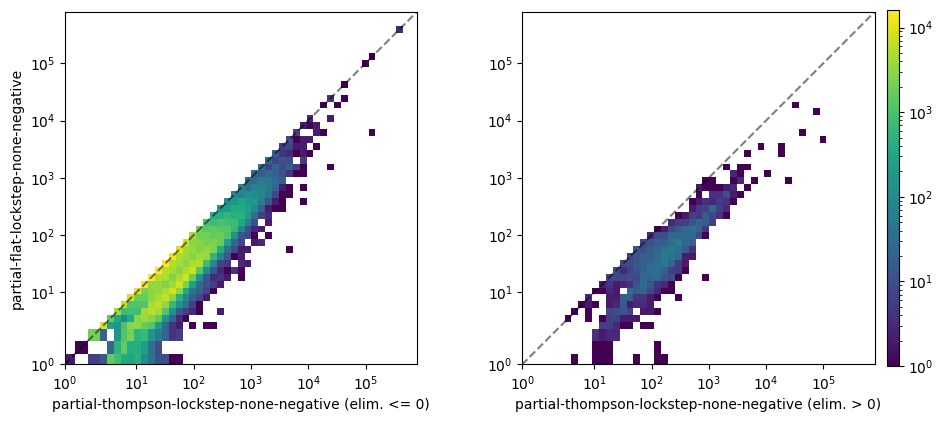

In [5]:
# Histogram 2D
importlib.reload(plt)

logging.basicConfig(level=logging.WARNING, stream=sys.stderr, force=True)
options = itertools.product(
    ['full', 'partial'],
    [('spencer', 'none'), ('spencer', 'cn'),
     ('spencer', 'in'), ('lockstep', 'none')],
    ['positive', 'negative']
)
threshold = 0

for matching_type, (scheduler, memo_scheme), input_type in options:
    filename = Path(
        "-".join([matching_type, scheduler, memo_scheme, input_type]))
    xs = states[matching_type]['thompson'][scheduler][memo_scheme][input_type]
    ys = states[matching_type]['flat'][scheduler][memo_scheme][input_type]
    xlabel = "-".join(
        [matching_type, 'thompson', scheduler, memo_scheme, input_type])
    ylabel = "-".join(
        [matching_type, 'flat', scheduler, memo_scheme, input_type])
    zs = eliminateds[memo_scheme][input_type]

    # Range excluding outliers
    total = xs + ys
    quartile_1 = np.quantile(total, 0.25)
    quartile_3 = np.quantile(total, 0.75)
    iqr = quartile_3 - quartile_1
    maximum = np.max(
        total, where=xs <= quartile_3 + 1.5 * iqr, initial=-np.inf)
    minimum = np.min(total, where=xs >= quartile_1 - 1.5 * iqr, initial=np.inf)
    x_space = np.geomspace(1, max(xs+ys), 50)
    y_space = np.geomspace(1, max(ys+ys), 50)

    _h1, _, _ = np.histogram2d(
        xs[zs <= threshold], ys[zs <= threshold], bins=(x_space, y_space))
    _h2, _, _ = np.histogram2d(
        xs[zs > threshold], ys[zs > threshold], bins=(x_space, y_space))
    vmax = max(np.max(_h1), np.max(_h2))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    h, _, _, cmap = axes[0].hist2d(
        xs[zs <= threshold], ys[zs <= threshold],
        bins=(x_space, y_space), norm='log', vmin=1, vmax=vmax
    )
    axes[0].set_xscale('symlog')
    axes[0].set_yscale('symlog')
    axes[0].set_xlabel(xlabel + f" (elim. <= {threshold})")
    axes[0].set_ylabel(ylabel)
    axes[0].axis('square')

    axes[1].hist2d(xs[zs > threshold], ys[zs > threshold], bins=(
        x_space, y_space), norm='log', vmin=1, vmax=vmax)
    axes[1].set_xscale('symlog')
    axes[1].set_yscale('symlog')
    axes[1].set_xlabel(xlabel + f" (elim. > {threshold})")
    axes[1].axis('square')
    maximum = max(np.max(xs), np.max(ys))

    axes[0].plot(
        [0, maximum], [0, maximum], alpha=0.5, color='black', linestyle='--')
    axes[1].plot(
        [0, maximum], [0, maximum], alpha=0.5, color='black', linestyle='--')

    fig.subplots_adjust(right=0.8)
    axes[1].get_position()
    pos = axes[1].get_position()
    cbar_ax = fig.add_axes(
        [pos.x1 + 0.01, pos.y0 + 0.01, 0.01, pos.y1 - pos.y0 - 0.02])
    fig.colorbar(cmap, cax=cbar_ax)

    plt.subplots_adjust(wspace=0.3)
    output_dir = Path('./outputs/state')
    output_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_dir / filename)
    plt.show()

In [10]:
# state-full-lockstep-none
matching_type = 'full'
scheduler = 'lockstep'
memo_scheme = 'none'
input_types = ['positive', 'negative']
filename = Path("-".join(['state', matching_type, scheduler, memo_scheme]))

xs = np.concatenate([
    states[matching_type]['thompson'][scheduler][memo_scheme][input_type]
    for input_type in input_types
])
ys = np.concatenate([
    states[matching_type]['flat'][scheduler][memo_scheme][input_type]
    for input_type in input_types
])

xlabel = "-".join([matching_type, 'thompson', scheduler, memo_scheme])
ylabel = "-".join([matching_type, 'flat', scheduler, memo_scheme])

x_space = np.geomspace(1, max(xs+ys), 50)
y_space = np.geomspace(1, max(ys+ys), 50)
bins = (x_space, y_space)

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
h, _, _, cmap = axes.hist2d(xs, ys, bins=bins, norm='log')
axes.set_xscale('symlog')
axes.set_yscale('symlog')
axes.set_xlabel(xlabel)
axes.set_ylabel(ylabel)
axes.axis('square')
maximum = max(np.max(xs), np.max(ys))
axes.plot([0, maximum], [0, maximum], alpha=0.5, color='black', linestyle='--')
pos = axes.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.y1 - pos.y0])
fig.colorbar(cmap, cax=cbar_ax)
output_dir = Path('./outputs/case_study/')
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / filename.with_suffix('.pdf'))
plt.savefig(output_dir / filename.with_suffix('.pgf'))
plt.show()

In [11]:
# state-full-spencer-cn
matching_type = 'full'
scheduler = 'spencer'
memo_scheme = 'cn'
input_types = ['positive', 'negative']
filename = Path("-".join(['state', matching_type, scheduler, memo_scheme]))

xs = np.concatenate([
    states[matching_type]['thompson'][scheduler][memo_scheme][input_type]
    for input_type in input_types
])
ys = np.concatenate([
    states[matching_type]['flat'][scheduler][memo_scheme][input_type]
    for input_type in input_types
])

xlabel = "-".join([matching_type, 'thompson', scheduler, memo_scheme])
ylabel = "-".join([matching_type, 'flat', scheduler, memo_scheme])

x_space = np.geomspace(1, max(xs+ys), 50)
y_space = np.geomspace(1, max(ys+ys), 50)
bins = (x_space, y_space)

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
h, _, _, cmap = axes.hist2d(xs, ys, bins=bins, norm='log')
axes.set_xscale('symlog')
axes.set_yscale('symlog')
axes.set_xlabel(xlabel)
axes.set_ylabel(ylabel)
axes.axis('square')
maximum = max(np.max(xs), np.max(ys))
axes.plot([0, maximum], [0, maximum], alpha=0.5, color='black', linestyle='--')
pos = axes.get_position()
cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.y1 - pos.y0])
fig.colorbar(cmap, cax=cbar_ax)
output_dir = Path('./outputs/case_study/')
output_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(output_dir / filename.with_suffix('.pdf'))
plt.savefig(output_dir / filename.with_suffix('.pgf'))
plt.show()